### Binary cross entropy loss
\begin{equation*}
L(\theta) = - \frac{1}{n} \sum_{i=1}^n [y_i log(p_i) + (1 - y_i) log(1 - p_i)]
\end{equation*}

- Discriminator final probability is 1 => REAL IMAGE
- Discriminator final probability is 0 => FAKE IMAGE

Log values:
- Log(1) => Loss would be 0
- Log(0+) => Loss would be to - ∞

### Generator:

Maximize D(G(z))


### Discriminator:

Maximize D(x) AND minimize D(G(z))

### https://github.com/soumith/ganhacks

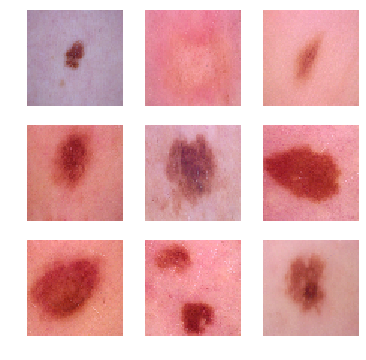

In [40]:
# Show some samples
fig = plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow( ( (X_train[i] * 127.5) + 127.5 ).astype(np.uint8) )
    plt.axis('off')

In [38]:
'''(X_tmp, Y_train), _ = mnist.load_data()
X_train = []
for img in X_tmp:
    tmp = cv2.resize(img, (int(64),int(64)), interpolation = cv2.INTER_CUBIC)
    X_train.append(tmp)
    #X_train.append(img)
    
# Expand to have 1 channel (grey images)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# Print max and min and normalize
print("MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))
X_train = normalize(X_train, -1, 1)
print("Normalized MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))

assert(X_train.shape[1] == X_train.shape[2])'''

'(X_tmp, Y_train), _ = mnist.load_data()\nX_train = []\nfor img in X_tmp:\n    tmp = cv2.resize(img, (int(64),int(64)), interpolation = cv2.INTER_CUBIC)\n    X_train.append(tmp)\n    #X_train.append(img)\n    \n# Expand to have 1 channel (grey images)\nX_train = np.expand_dims(X_train, axis=-1)\nprint(X_train.shape)\n\n# Print max and min and normalize\nprint("MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))\nX_train = normalize(X_train, -1, 1)\nprint("Normalized MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))\n\nassert(X_train.shape[1] == X_train.shape[2])'